In [3]:
import scanpy as sc
import os
import glob
import pandas as pd
from anndata import AnnData
from scipy.io import mmread
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

---
    - Author: Shankara Anand

    - Email: sanand@broadinstitute.org

---

In [4]:
PLOTS_DIR = "plots"
sc.set_figure_params(fontsize=10)

colors = """
Adipocyte	Adipocyte	Stromal	Adipose	#745745
Endothelial cell (lymphatic)	Endothelial cell	Stromal	Endothelial 	#568F34
Endothelial cell (vascular)	Endothelial cell	Stromal	Endothelial 	#324C20
Epithelial cell (alveolar type I)	Epithelial cell	Epithelial	Epithelial	#C9A997
Epithelial cell (alveolar type II)	Epithelial cell	Epithelial	Epithelial	#C62026
Epithelial cell (basal keratinocyte)	Epithelial cell (keratinocyte)	Epithelial	Epithelial	#F78F82
Epithelial cell (basal)	Epithelial cell	Epithelial	Epithelial	#EF4C1F
Epithelial cell (basal/suprabasal)	Epithelial cell	Epithelial	Epithelial	#FF891C
Epithelial cell (ciliated)	Epithelial cell	Epithelial	Epithelial	#FACB12
Epithelial cell (club)	Epithelial cell	Epithelial	Epithelial	#C19F70
Epithelial cell (cornified keratinocyte)	Epithelial cell	Epithelial	Epithelial	#824D18
Epithelial cell (Hillock)	Epithelial cell	Epithelial	Epithelial	#FF891C
Epithelial cell (luminal)	Epithelial cell	Epithelial	Epithelial	#CB7513
Epithelial cell (mature keratinocyte)	Epithelial cell (keratinocyte)	Epithelial	Epithelial	#FBBE92
Epithelial cell (squamous)	Epithelial cell	Epithelial	Epithelial	#CEA636
Epithelial cell (suprabasal keratinocyte)	Epithelial cell (keratinocyte)	Epithelial	Epithelial	#F9DECF
Epithelial cell (suprabasal)	Epithelial cell	Epithelial	Epithelial	#9B645F
Epithelial cell (suprabasal/squamous)	Epithelial cell	Epithelial	Epithelial	#635547
Fibroblast	Fibroblast	Stromal	Fibroblast	#502888
ICCs	Muscle	Stromal	Other	#F7F79E
Immune (alveolar macrophage)	Immune (myeloid)	Immune	Immune	#005579
Immune (B cell)	Immune (lymphocyte)	Immune	Immune	#007F76
Immune (DC)	Immune (myeloid)	Immune	Immune	#00A99D
Immune (DC/macrophage)	Immune (myeloid)	Immune	Immune	#3EE5E1
Immune (Langerhans)	Immune (myeloid)	Immune	Immune	#65C8D0
Immune (macrophage)	Immune (myeloid)	Immune	Immune	#0071BC
Immune (mast cell)	Immune (myeloid)	Immune	Immune	#C9EBFB
Immune (NK cell)	Immune (lymphocyte)	Immune	Immune	#3E84AA
Immune (T cell)	Immune (lymphocyte)	Immune	Immune	#8CB4CD
Melanocyte	Melanocyte	Epithelial	Epithelial	#000000
Mucous cell	Epithelial cell	Epithelial	Epithelial	#959595
Myocyte (sk. muscle)	Muscle	Stromal	Muscle	#E8529A
Myocyte (sk. muscle, cytoplasmic)	Muscle	Stromal	Muscle	#F397C0
Myocyte (smooth muscle)	Muscle	Stromal	Muscle	#DECCE3
Myocyte (cardiac)	Muscle	Stromal	Muscle	#C593BF
Myocyte (cardiac, cytoplasmic)	Muscle	Stromal	Muscle	#6853A0
Myocyte (NMJ-rich)	Muscle	Stromal	Muscle	#B51D8D
Myoepithelial (basal)	Epithelial cell	Epithelial	Epithelial	#E18256
Myofibroblast	Stromal	Stromal	Fibroblast	#9BAA67
Neuroendocrine	Epithelial cell	Epithelial	Other	#8ac28e
Neuronal	Neuron	Neuron	Other	#68926b
Pericyte	Muscle	Stromal	Other	#8CC63F
Pericyte/SMC	Muscle	Stromal	Other	#647A4F
Satellite cell	Muscle	Stromal	Other	#CFE289
Schwann cell	Glia	Glia	Other	#00C609
Sebaceous gland cell	Epithelial cell	Epithelial	Epithelial	#C64B55
Sweat gland cell	Epithelial cell	Epithelial	Epithelial	#953840
Unknown	Other	Other	Other	#D5D5D5
""".strip().split('\n')

colors = {x.split('\t')[0]:x.split('\t')[4] for x in colors}

## 1. Load GTEx sNuc-Seq
---

In [ ]:
GTEX_PATH = "data/gtex/data-v19-compressed-20210204.h5ad"

In [6]:
gtex_ad = sc.read(GTEX_PATH)
gtex_lv = gtex_ad[gtex_ad.obs['tissue']=='heart']
gtex_lv.write("data/gtex/lv_ad.h5ad")

In [ ]:
gtex_lv = sc.read("data/gtex/lv_ad.h5ad")
gtex_lv.obs = gtex_lv.obs.rename(columns={'prep':'buffer','Participant_ID':'IndividualID'})
gtex_lv.obs['orig_ident'] = gtex_lv.obs['tissue-individual-prep']
gtex_raw = AnnData(gtex_lv.layers['counts'], var=gtex_lv.var, obs=gtex_lv.obs)

## 2. Load Ellinor Data
---

Retrieved from [Single Cell Portal](https://singlecell.broadinstitute.org/single_cell/study/SCP498/transcriptional-and-cellular-diversity-of-the-human-heart).

In [ ]:
ELI_COUNTS = "data/ellinor/gene_sorted-matrix.mtx"
ELI_H5 = "data/ellinor/healthy_human_4chamber_map_unnormalized_V3.h5ad"

In [ ]:
X = mmread(ELI_COUNTS)

ad_eli = sc.read(ELI_H5)
ad_eli.layers['counts'] = ad_eli.X

X = csc_matrix(X)
ad_eli.X = X.T

ad_eli_lv = ad_eli[ad_eli.obs['chamber']=='LV']
ad_eli_lv.write('data/ellinor/lv_ad.h5ad')

In [57]:
type_map = {
    'Fibroblast I': "Fibroblast",
    'Fibroblast II': "Fibroblast",
    'Atrial Cardiomyocyte':"Myocyte (cardiac)",
    'Ventricular Cardiomyocyte I':"Myocyte (cardiac)",
    'Cytoplasmic Cardiomyocyte I':"Myocyte (cardiac, cytoplasmic)",
    'Ventricular Cardiomyocyte II':"Myocyte (cardiac)",
    'Pericyte': "Pericyte/SMC",
    'Macrophage': "Immune (DC/macrophage)",
    'Endothelium I': "Endothelial cell (vascular)",
    'Endothelium II': "Endothelial cell (vascular)",
    'Adipocyte':"Adipocyte",
    'Cytoplasmic Cardiomyocyte II': "Myocyte (cardiac, cytoplasmic)",
    'Vascular Smooth Muscle': "Pericyte/SMC",
    'Fibroblast III': "Fibroblast",
    'Ventricular Cardiomyocyte III': "Myocyte (cardiac)",
    'Neuronal':"Schwann cell",
    'Lymphocyte': "Immune (T cell)",
}

In [16]:
ad_eli_lv = sc.read("data/ellinor/lv_ad.h5ad")
ad_eli_lv.obs['Cluster'] = ad_eli_lv.obs['Cluster'].apply(lambda x: x[4:]).values

# Adjust annotations
ad_eli_lv.obs['Broad cell type'] = ad_eli_lv.obs['Cluster'].apply(lambda x: type_map[x])

# Rename Obs
ad_eli_lv.obs = ad_eli_lv.obs.rename(columns={'biological.individual':'IndividualID'})
ad_eli_lv.obs['buffer']= "ELI"

eli_raw = AnnData(ad_eli_lv.layers['counts'], var=ad_eli_lv.var, obs=ad_eli_lv.obs)
eli_raw.obs['orig_ident'] = eli_raw.obs['experiment']

## 2.1 Combine GTEx & Ellinor
---

Normalize & process data.

In [ ]:
# Concat
adata = gtex_raw.concatenate(eli_raw)
adata.obs['IndividualID'] = adata.obs['IndividualID'].astype('category')

In [15]:
def _name(x):
    if x=='0':
        return 'GTEx'
    else:
        return 'ELI'

adata.obs['batch'] = adata.obs['batch'].apply(_name)

In [24]:
hvg = {'min_mean':0.0125, 'max_mean':3, 'min_disp':0.5}

In [27]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
mito_genes = adata.var_names.str.startswith('MT-')
ribo_genes = adata.var_names.str.startswith('RPS') + adata.var_names.str.startswith('RPL')

# Filter by grouped mito-thresholds
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
m = adata.obs['percent_mito']
adata.layers['counts'] = adata.X.copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
sc.pp.log1p(adata)
adata.raw = adata.copy()
sc.pp.highly_variable_genes(adata, **hvg)

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.louvain(adata, resolution=1)
sc.tl.umap(adata)

## 3. Load & Process Teichmann
---

Retreived from [HCA](https://www.heartcellatlas.org/).

In [ ]:
TEICHMANN_GLOBAL = "data/teichmann/global.h5ad"
TEICHMANN_IMMUNE = "data/teichmann/immune.h5ad"

In [30]:
adatas_teichmann = {}
adatas_teichmann['global_'] = sc.read(TEICHMANN_GLOBAL)
adatas_teichmann['immune'] = sc.read(TEICHMANN_IMMUNE)

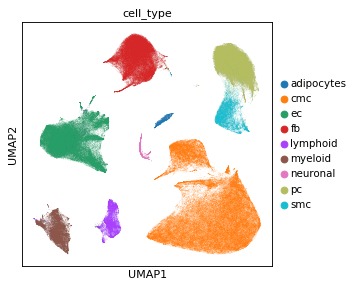

In [31]:
sc.pl.umap(adatas_teichmann['global_'], color='cell_type')

In [32]:
teichmann_type_map = {
    "adipocytes":"Adipocyte",
    "cmc":"Myocyte (cardiac)",
    "ec": "Endothelial cell (vascular)",
    "fb":"Fibroblast",
    "lymphoid":"Immune (T cell)",
    "myeloid":"Immune (DC/macrophage)",
    "neuronal":"Schwann cell",
    "pc":"Pericyte/SMC",
    "smc": "Pericyte/SMC"
}

adatas_teichmann["global_"].obs['Broad cell type'] = adatas_teichmann["global_"].obs['cell_type'].apply(lambda x: teichmann_type_map[x])
adatas_teichmann["global_"].obs['Broad cell type'] = adatas_teichmann["global_"].obs['Broad cell type'].astype('category')
adatas_teichmann["global_"].uns['Broad cell type_colors'] = [colors[x] for x in adatas_teichmann["global_"].obs['Broad cell type'].cat.categories]

### Pull Immune Annotations

In [33]:
def _rename(x):
    if x in ('B_cells'):
        return 'Immune (B cell)'
    elif 'T_' in x:
        return 'Immune (T cell)'
    elif 'DC' in x or 'MØ' in x or 'Mo' in x:
        return 'Immune (DC/macrophage)'
    elif 'Mast' in x:
        return 'Immune (mast cell)'
    elif 'NK' in x:
        return 'Immune (NK cell)'
    else:
        return x

immune_teichmann = adatas_teichmann['immune'].obs.copy()
immune_teichmann.index = immune_teichmann.reset_index()['index'].astype(str) + '-' + immune_teichmann['cell_source'].astype(str).values

adatas_teichmann['immune'].obs['Broad cell type'] = immune_teichmann['cell_states'].apply(lambda x: _rename(x)).values
adatas_teichmann['immune'].obs_names = immune_teichmann.index

... storing 'Broad cell type' as categorical


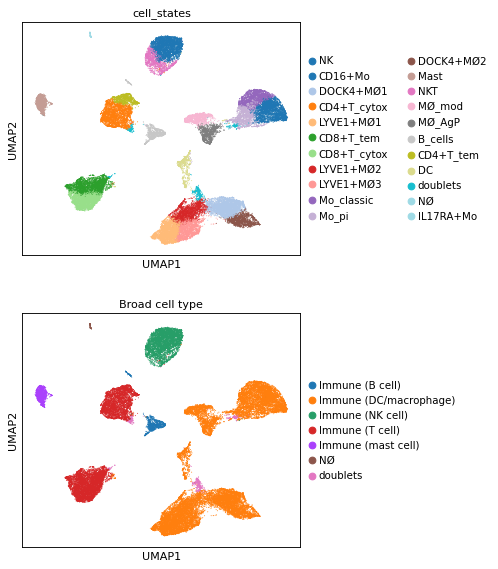

In [34]:
sc.pl.umap(adatas_teichmann['immune'], color=['cell_states', 'Broad cell type'], ncols=1)

In [35]:
rn_dict = adatas_teichmann['immune'].obs['Broad cell type'].to_dict()

def _rename(row):
    if row.name in rn_dict.keys():
        return rn_dict[row.name]
    else:
        return row['Broad cell type']
adatas_teichmann['global_'].obs['Broad cell type'] = adatas_teichmann['global_'].obs.apply(_rename, 1)

... storing 'Broad cell type' as categorical


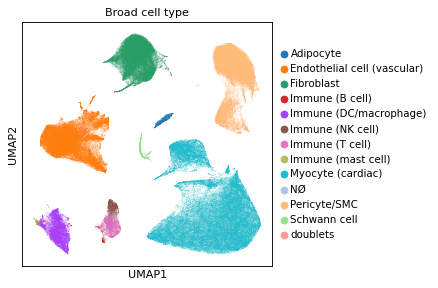

In [37]:
sc.pl.umap(adatas_teichmann["global_"], color=['Broad cell type'])

In [38]:
ad_teichmann_lv = adatas_teichmann["global_"][adatas_teichmann["global_"].obs['region']=='LV']
ad_teichmann_lv.obs['orig_ident'] = ad_teichmann_lv.obs['sample']
ad_teichmann_lv.obs['IndividualID'] = ad_teichmann_lv.obs['donor']

ad_teichmann_nuclei = ad_teichmann_lv[ad_teichmann_lv.obs['cell_source'].isin(['Harvard-Nuclei','Sanger-Nuclei'])]

/home/sanand/.conda/envs/scrna/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [268]:
ad_teichmann_lv.write("data/teichmann/teichmann_lv_full.h5")
ad_teichmann_nuclei.write("data/teichmann/teichmann_lv_nuclei.h5")

## 4. Integration of 3 Heart Single-Nuclei Datasets
---

In [ ]:
import harmonypy as hm

In [42]:
comb_ad = AnnData(adata.raw.X, obs=adata.obs, var=adata.var)
comb_ad = comb_ad.concatenate(ad_teichmann_nuclei)
comb_ad.raw = comb_ad.copy()

# Select HVGs
hvg = {'min_mean':0.0125, 'max_mean':3, 'min_disp':0.5}

sc.pp.highly_variable_genes(comb_ad,**hvg)
sc.pp.scale(comb_ad, max_value=10)
sc.tl.pca(comb_ad, svd_solver='arpack', use_highly_variable=True)

# Run Harmony
data_mat = pd.DataFrame(comb_ad.obsm['X_pca'], index=comb_ad.obs_names)
meta_data = comb_ad.obs
ho = hm.run_harmony(data_mat, meta_data, ['IndividualID'])

# Add corrected PCA
comb_ad.obsm['X_pca_h'] = ho.Z_corr.T

sc.pp.neighbors(comb_ad, use_rep='X_pca_h')
sc.tl.louvain(comb_ad, resolution=1)
sc.tl.umap(comb_ad)

In [45]:
def _assign_src(x):
    if x=='ELI':
        return "Ellinor"
    elif x is np.nan:
        return "Teichmann"
    else:
        return "GTEx"
    
def _annotate_cytoplasmic_myocytes(row):
    if row['source_exp']=='Teichmann':
        if row['Broad cell type'] == 'Myocyte (cardiac)' and row['louvain']=='7':
            return 'Myocyte (cardiac, cytoplasmic)'
        else:
            return row['Broad cell type']
    else:
        return row['Broad cell type']

In [53]:
comb_ad.obs['source_exp'] = comb_ad.obs['buffer'].apply(lambda x: _assign_src(x))
comb_ad = comb_ad[comb_ad.obs['Broad cell type']!='doublets']

comb_ad.obs['Broad cell type'] = comb_ad.obs.apply(_annotate_cytoplasmic_myocytes,1)
comb_ad.obs['Broad cell type'] = comb_ad.obs['Broad cell type'].astype('category')
comb_ad.uns['Broad cell type_colors'] = [colors[x] for x in comb_ad.obs['Broad cell type'].cat.categories]

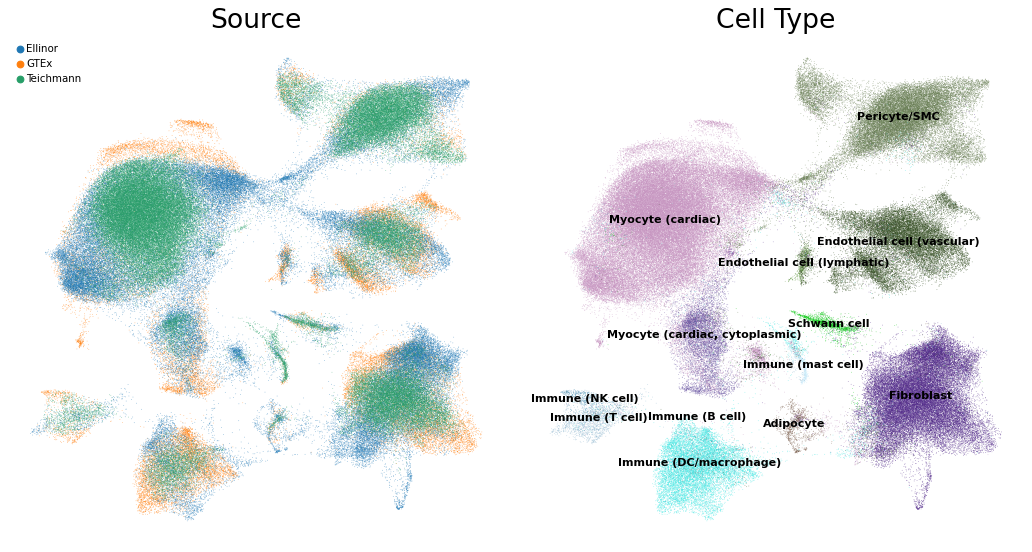

In [54]:
fig,axes = plt.subplots(1,2,figsize=(13,7))

sc.pl.umap(comb_ad, color='source_exp', ax=axes[0], show=False, s=2, frameon=False, alpha=0.6)
axes[0].legend(loc='upper left', frameon=False)
axes[0].set_title("Source", fontsize=24)

sc.pl.umap(comb_ad, color='Broad cell type', ax=axes[1], show=False, s=2, legend_loc ="on data", frameon=False, alpha=0.6)
axes[1].set_title("Cell Type", fontsize=24)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "umap_gtex_eli_teichmann.pdf"), bbox_inches='tight')

In [331]:
comb_ad.write("data/gtex_eli_teichmann_comb.h5")

In [340]:
comb_ad.obs[['source_exp','Broad cell type','IndividualID','orig_ident']].to_csv(
    "data/gtex_eli_teichmann_comb_meta.tsv", sep='\t'
)

In [341]:
comb_ad.obs.groupby(['source_exp','Broad cell type']).size()

source_exp  Broad cell type               
Ellinor     Adipocyte                           755
            Endothelial cell (lymphatic)          0
            Endothelial cell (vascular)        9050
            Fibroblast                        16741
            Immune (B cell)                       0
            Immune (DC/macrophage)             4481
            Immune (NK cell)                      0
            Immune (T cell)                     745
            Immune (mast cell)                    0
            Myocyte (cardiac)                 34161
            Myocyte (cardiac, cytoplasmic)     3814
            Pericyte/SMC                       8039
            Schwann cell                        478
GTEx        Adipocyte                           193
            Endothelial cell (lymphatic)        565
            Endothelial cell (vascular)        7070
            Fibroblast                         9287
            Immune (B cell)                      22
            Immune (D